<a href="https://colab.research.google.com/github/wilsonfmjr/PPGEEC2321---REDES-NEURAIS-E-DEEP-LEARNING/blob/main/Questao_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importando bibliotecas

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import alexnet
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

#Preparação dos dados

In [ ]:
# 1. Transformações (AlexNet espera 224x224 e normalização do ImageNet)
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 2. Carregar dados CIFAR-10
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:05<00:00, 32.8MB/s]


#Carrega AlexNet pré-treinada e adapta para CIFAR-10

In [ ]:
# 3. Carregar AlexNet pré-treinada
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = alexnet(pretrained=True)

# 4. Congelar TODAS as camadas (feature extractor)
for param in model.parameters():
    param.requires_grad = False

# 5. Substituir apenas a última camada do classificador
num_classes = 10
model.classifier[6] = nn.Linear(4096, num_classes)

# Agora apenas essa camada será treinada
model = model.to(device)

# 6. Otimizador e função de perda
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier[6].parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 132MB/s]


#Treinamento do modelo

In [ ]:
# 7. Treinar somente o classificador
num_epochs = 5  # pode aumentar para melhorar desempenho
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Época {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")


Época 1, Loss: 0.6853
Época 2, Loss: 0.6244
Época 3, Loss: 0.6098
Época 4, Loss: 0.6026
Época 5, Loss: 0.5868


[texto do link](https://)# Data Preparation

#Matriz de confusão

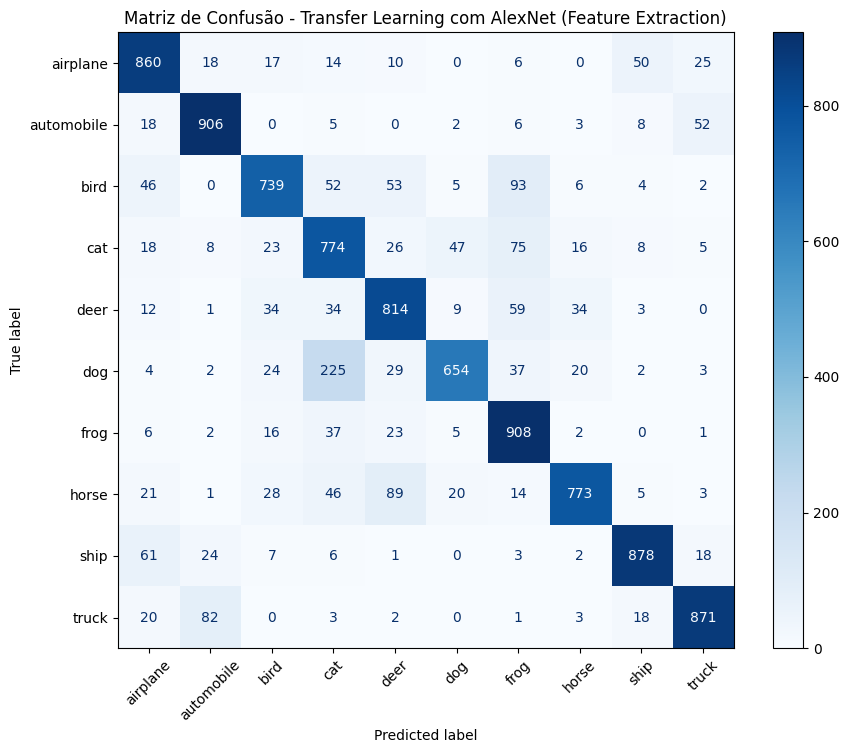

In [ ]:
# 8. Avaliação e matriz de confusão
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# 9. Matriz de confusão
cm = confusion_matrix(all_labels, all_preds)
labels_names = test_dataset.classes

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusão - Transfer Learning com AlexNet (Feature Extraction)")
plt.show()